In [23]:
import os
import re
import sys
import time
import shutil
import copy
import glob
import numpy as np
import itertools
import importlib
import multiprocessing
import multiprocessing.pool
import fnmatch
import segyio
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from skimage import restoration
from scipy import signal, ndimage
from natsort import natsorted
import seaborn as sns
sys.path.append(('./utils'))
import mgen
import datasetmaker
import shared as sd
import loaders as ld
import vis
import random
from IPython.display import clear_output
# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api
print(f'Python: {sys.prefix}')

Python: /home/plotnips/anaconda3/envs/lw


/tmp/ipykernel_15617/516062380.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 150,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [3]:
#     cmap = 'gist_ncar'
def is_empty(p): return False if (os.path.exists(p) and [f for f in os.listdir(p) if f != '.gitignore']) else True

def divmax(x): return x / np.max(np.abs(x))
    
def load_bin(p, dims): 
    f = open(p); vp = np.fromfile (f, dtype=np.dtype('float32').newbyteorder ('<')); f.close();
    vp = vp.reshape(*dims); vp = np.transpose(vp); vp = np.flipud(vp); print(f"{vp.shape}"); return vp

def plot_model(v, title='', axis='on', **kwargs): 
    plt.figure(); ax = plt.gca(); im = ax.imshow(np.flipud(v), cmap='RdBu_r', **kwargs); plt.axis(axis); plt.title(title); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);plt.colorbar(im, cax=cax); plt.pause(0.001)
    return ax

def plot_logs(m1, m2, idx=2, title=''):
    plt.figure(); plt.plot(m1.vp[::-1,idx], 'k--'); plt.plot(m1.vs[::-1,idx], 'k--'); plt.plot(m1.rho[::-1,idx], 'k--');
    plt.plot(m2.vp[::-1,idx], label='vp'); plt.plot(m2.vs[::-1,idx], label='vs'); plt.plot(m2.rho[::-1,idx], label='rho'); plt.legend() 
def extend(x, ez, ex):
    if ex > 0:
        x = np.concatenate((x, np.flip(x[:, -ex:], -1)), 1)              # OX
    if ez > 0:
        x = np.concatenate((x, x.min() * np.ones((ez, x.shape[1]))), 0)  # OZ
    return x
def plot_log_model(mm, dx, nx, nz0, _src):
    v = mm.copy() / 1000
    plt.figure(); ax = plt.gca();
    map_src = _src.x / dx < nx
    plt.scatter(_src.x[map_src]/1000, _src.y[map_src]/1000, 1, color='w'); 
    cmap='RdBu_r'
    im = ax.imshow(v[:,:nx0], cmap=cmap, extent=[0, nx0 * dx / 1000, 0, nz0 * dx/1000], 
                   origin='upper', vmin=1.45, vmax=3.5); 
    divider = make_axes_locatable(ax); 
    cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax); cbar.set_label('km/s');
    ax.set_xlabel('km'); ax.set_ylabel('km'); ax.set_title(f); ax.invert_yaxis();

    log = model_log.vp[:, log_idx]
    vh = 420*dx * np.ones_like(log)/ 1000 
    ax.plot(vh, np.arange(len(log))*dx/1000, 'k--')
    ax.plot(vh + (log[::-1] - min(log)) / 1000, np.arange(len(log))*dx/1000, 'k')
    plt.pause(0.001)

In [4]:
root_fwi = './out_ac/'
root_out = '/data/oleg/data/'
root_field = os.path.join('./data_cgg/')
# Data loading
# data_paths='/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496'
# data_paths='/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496_test4'
data_paths=[
            '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496',
            '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496_test4']
data_paths=['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling']
data_paths=['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_09_09_standardization']
data_paths=['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/plotting_dataset2']
dx=25;dz=25
########################## find directories in the folder
files=[]
for data_path in data_paths:
    tmp=fnmatch.filter(os.listdir(data_path),'*.npz')
    for file_ in tmp:
        path_=os.path.join(data_path,file_)
        files.append(path_)

In [5]:
##########################
# files=fnmatch.filter(os.listdir(data_path),'*.npz')
test = fnmatch.filter(files, '*__*'); print(len(test)); 
#print(test)
for i,j in enumerate(test): print(i,j.split('/')[-1])
print(test[0])
test2=[test[4],
       test[0],
       test[2],
       test[8]]
test2=[test[4],
       test[5],
#        test[8]
      ]
for i,j in enumerate(test2): print(i,j.split('/')[-1])
train=list(set(files)-set(test))
# test=list(set(test)-set(fnmatch.filter(files, '*_bad_initial*')))
train=train[0:1200]
print(len(files))
print('Size of training dataset',len(train))
print('Size of testing dataset',len(test))
# print(len(train+test))

10
0 model__Seam_linear_initial.npz
1 model__Seam2.npz
2 model__Seam.npz
3 model__cgg_lin_vp_long.npz
4 model__Marmousi.npz
5 model__Overthrust.npz
6 model__Overthrust_linear_initial.npz
7 model__Marmousi_linear_initial.npz
8 model__cgg_tomo_long2.npz
9 model__Seam2_linear_initial.npz
/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/plotting_dataset2/model__Seam_linear_initial.npz
0 model__Marmousi.npz
1 model__Overthrust.npz
2688
Size of training dataset 1200
Size of testing dataset 10


In [6]:
from functools import partial
def unpack_file(NAME):
    pts=NAME.split('/')
    f_name=pts[-1]
    f_name=f_name[:-4]; 
    # print('reading ',f_name)
    with open(NAME, 'rb') as f:
        data=np.load(f)
        model=data['models'].squeeze()
        initial_model=data['models_init'].squeeze()
        input_data=data['input_data'].squeeze()
        output_data=data['output_data'].squeeze()
        input_data_real_amplitudes=data['input_data_real_amplitudes'].squeeze()
        output_data_real_amplitudes=data['output_data_real_amplitudes'].squeeze()
        data.close()
    fwi_result=input_data_real_amplitudes+initial_model
    data_structure={'model':model.T,'initial_model':initial_model.T,'input_data':input_data.T,'input_data_real_amplitudes':input_data_real_amplitudes.T
        ,'output_data_real_amplitudes':output_data_real_amplitudes.T,'name':f_name,'output_data':output_data.T,'fwi_result':fwi_result.T}
    # Plot_image(M0.T,Show_flag=0,Save_flag=1,Save_pictures_path=Save_pictures_path,Title=f_name+'_M0',Aspect='equal')
    # Plot_image(M2.T,Show_flag=0,Save_flag=1,Save_pictures_path=Save_pictures_path,Title=f_name+'_M2',Aspect='equal')
    return data_structure
def extract_structure_field(list_of_structures,field):
    list_of_arrays=[]
    for i in range(len(list_of_structures)):
        list_of_arrays.append( list_of_structures[i][field] )
    return list_of_arrays
print(multiprocessing.cpu_count())
flag_single_thread_processing=1
LIST=test
test_models_data=[]
dataset_models_data=[]
if flag_single_thread_processing == 1:
    for NAME in test2:
        data_structure=unpack_file(NAME)
        test_models_data.append(data_structure)
    for NAME in train:
        data_structure=unpack_file(NAME)
        dataset_models_data.append(data_structure)
        # test_models_data.append([model,initial_model])
    # print(test_models_data[0]['input_data'])
elif flag_single_thread_processing==0:
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-5)
    temp = partial(unpack_file)
    test_models_data = pool.map(func=temp, iterable=test2)
    pool.close()
    pool.join()
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-5)
    temp = partial(unpack_file)
    dataset_models_data = pool.map(func=temp, iterable=train)
    pool.close()
    pool.join()

48


In [7]:
fwi_result_train=extract_structure_field(dataset_models_data,'fwi_result')
fwi_result_train=np.asarray(fwi_result_train,dtype=np.float32)
print('print(fwi_result_train.min())',fwi_result_train.min())
print('print(fwi_result_train.max())',fwi_result_train.max())

fwi_result_test=extract_structure_field(test_models_data,'fwi_result')
for f in fwi_result_test:
    Min=np.min(f)
    Max=np.max(f)
    print(Min)
for f in fwi_result_test:
    Min=np.min(f)
    Max=np.max(f)
    print(Max)

other_models_inp_data=extract_structure_field(dataset_models_data,'input_data_real_amplitudes')
other_models_inp_data=np.asarray(other_models_inp_data,dtype=np.float32)
other_models=extract_structure_field(dataset_models_data,'model')
other_models=np.asarray(other_models,dtype=np.float32)
other_models_initial_model=extract_structure_field(dataset_models_data,'initial_model')
other_models_initial_model=np.asarray(other_models_initial_model,dtype=np.float32)
print('print(other_models_inp_data.min())',other_models_inp_data.min())
print('print(other_models_inp_data.max())',other_models_inp_data.max())
print('print(other_models_initial_model.min())',other_models_initial_model.min())
print('print(other_models_initial_model.max())',other_models_initial_model.max())
print('print(other_models.min())',other_models.min())
print('print(other_models.max())',other_models.max())
print(len(other_models_inp_data))
print((other_models_inp_data.shape))
input_data=np.asarray(extract_structure_field(dataset_models_data,'input_data'),dtype=np.float32)
output_data=np.asarray(extract_structure_field(dataset_models_data,'output_data'),dtype=np.float32)
print('input_data.min',input_data.min(),'input_data.max',input_data.max())
print('input_data.min',output_data.min(),'input_data.max',output_data.max())
print(input_data.shape)
print(output_data.shape)
test_models_inp_data=extract_structure_field(test_models_data,'input_data')
for f in test_models_inp_data:
    Min=np.min(f)
    Max=np.max(f)
    print(Min)
    print(Max)
other_models_output_data=extract_structure_field(dataset_models_data,'output_data_real_amplitudes')
other_models_output_data=np.asarray(other_models_output_data,dtype=np.float32)
# print('print(other_models_output_data.min())',other_models_output_data.min())
# print('print(other_models_output_data.max())',other_models_output_data.max())
# print('print(other_models_output_data.min())',np.min(other_models_output_data))
# print('print(other_models_output_data.max())',np.max(other_models_output_data))
# print(other_models_output_data.shape)

print(fwi_result_train.min()) 1500.0
print(fwi_result_train.max()) 4458.207
1466.9808
1500.0
4280.123
4194.397
print(other_models_inp_data.min()) -1023.2051
print(other_models_inp_data.max()) 929.67285
print(other_models_initial_model.min()) 1500.0
print(other_models_initial_model.max()) 4159.6963
print(other_models.min()) 1500.0
print(other_models.max()) 4700.0
1200
(1200, 150, 496)
input_data.min -17.89095 input_data.max 16.602682
input_data.min -6.828497 input_data.max 6.731826
(1200, 150, 496)
(1200, 150, 496)
-13.950338
9.560373
-9.418975
9.662824


2
Save /home/plotnips/Dropbox/Apps/Overleaf/draft_Geophysics_FWI_init_model_prediction/paper_geophysics/Fig/vlogs.png


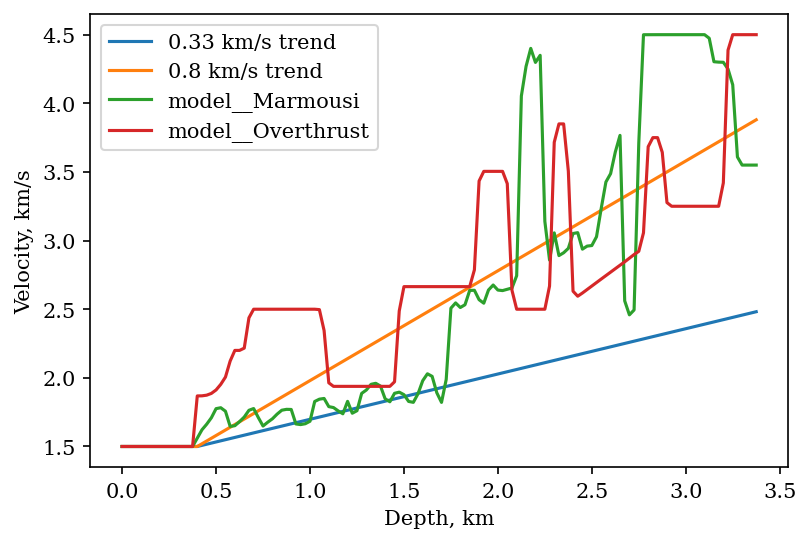

In [8]:
print(len(test_models_data))
############    data structure: model,initial_model,input_data,name
log_idx = 100
############## Linear trends
water_sz=int(400/dz)
zz = np.arange(136-water_sz) * dz
step=1500
water=np.ones((water_sz))*1500
zz_=dz*np.arange(len(np.concatenate([water,step + 0.2 * zz]))) / 1000
plt.plot(zz_,np.concatenate([water,step + 0.33 * zz])/1000,label='0.33 km/s trend')
plt.plot(zz_,np.concatenate([water,step + 0.8 * zz])/1000,label='0.8 km/s trend')
# plt.plot(zz_,np.concatenate([water,step + 1.15 * zz])/1000,label='1.3 km/s trend')
############## Testing models
for i in range(len(test_models_data)):
    log = test_models_data[i]['model'][0:136,log_idx]/1000
    plt.plot(dx * np.arange(len(log)) / 1000, log, alpha=1.0,label=test_models_data[i]['name'])
############## Vertical profile
loc_dist = 1.75
idx_dist = int(loc_dist * 1000 / dx)
plt.xlabel('Depth, km'); plt.ylabel('Velocity, km/s'); 
plt.legend();
vis.savefig('vlogs.png')

80/80
Before prep:	(80, 648, 3526)
Data cube:	(80, 324, 3000)
Extended cube:	(80, 324, 3100)
[80, 324, 3050] (80, 324, 3000)
[80, 324, 3150] (80, 324, 3100)
25.0
Assume even average spacing between sources
 150.0 m ~ 6 grid nodes
First source:	1125.0 m
Last source:	12950.0 m
150.0
name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets:	None
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]
(152, 600)
(152, 600)
(152, 500)
12500.0


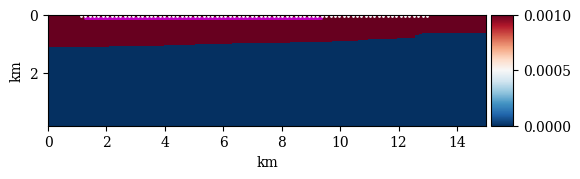

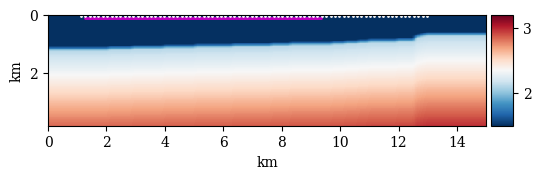

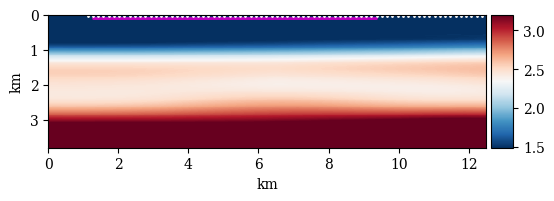

In [9]:
%run ./fwi_shared_check.ipynb

(116, 600)


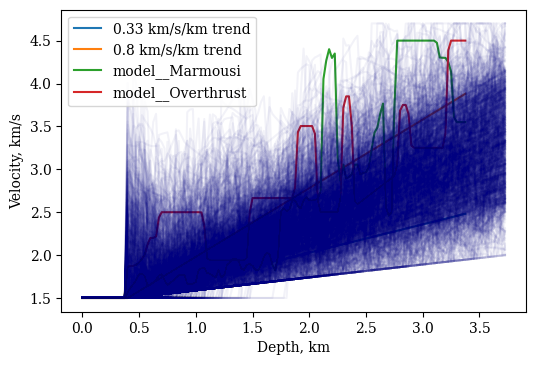

In [10]:
print(model_log.vp.shape)
log_idx = 100
############## Linear trends
water_sz=int(400/dz)
zz = np.arange(136-water_sz) * dz
step=1500
water=np.ones((water_sz))*1500
zz_=dz*np.arange(len(np.concatenate([water,step + 0.2 * zz]))) / 1000
plt.plot(zz_,np.concatenate([water,step + 0.33 * zz])/1000,label='0.33 km/s/km trend')
plt.plot(zz_,np.concatenate([water,step + 0.8 * zz])/1000,label='0.8 km/s/km trend')
# plt.plot(zz_,np.concatenate([water,step + 1.15 * zz])/1000,label='1.3 km/s trend')
############## Testing models
for i in range(len(test_models_data)):
    log = test_models_data[i]['model'][0:136,log_idx] / 1000
    plt.plot(dx * np.arange(len(log)) / 1000, log, alpha=1.0,label=test_models_data[i]['name'])
##############  Dataset models
nmodels=len(dataset_models_data)
for imodel in range(nmodels-1):
    log = dataset_models_data[imodel]['model'][:,log_idx] / 1000      # model
    xax = dx * np.arange(len(log)) / 1000
    plt.plot(xax, log, 'navy', alpha=0.05)
# Vertical profile
loc_dist = 1.75
idx_dist = int(loc_dist * 1000 / dx)
# plt.plot(np.ones_like(xax) * loc_dist, 
#          box_min/1000 + np.linspace(0, 1, len(xax)) * (box_max - box_min)/1000, 
#          'w--', lw=2)
# Mean profile
# plt.plot(xax, true_log, 'w', lw=6)
# plt.plot(xax, true_log, 'k--', lw=2, label='Init')
plt.xlabel('Depth, km'); 
plt.ylabel('Velocity, km/s')
plt.legend();
# vis.savefig('vlogs.png')
# log = other_models[nmodels-1][::-1, log_idx] / 1000
# plt.plot(xax, log, 'navy', alpha=0.1, label='Train')

25
1200
Marmousi
Overthrust


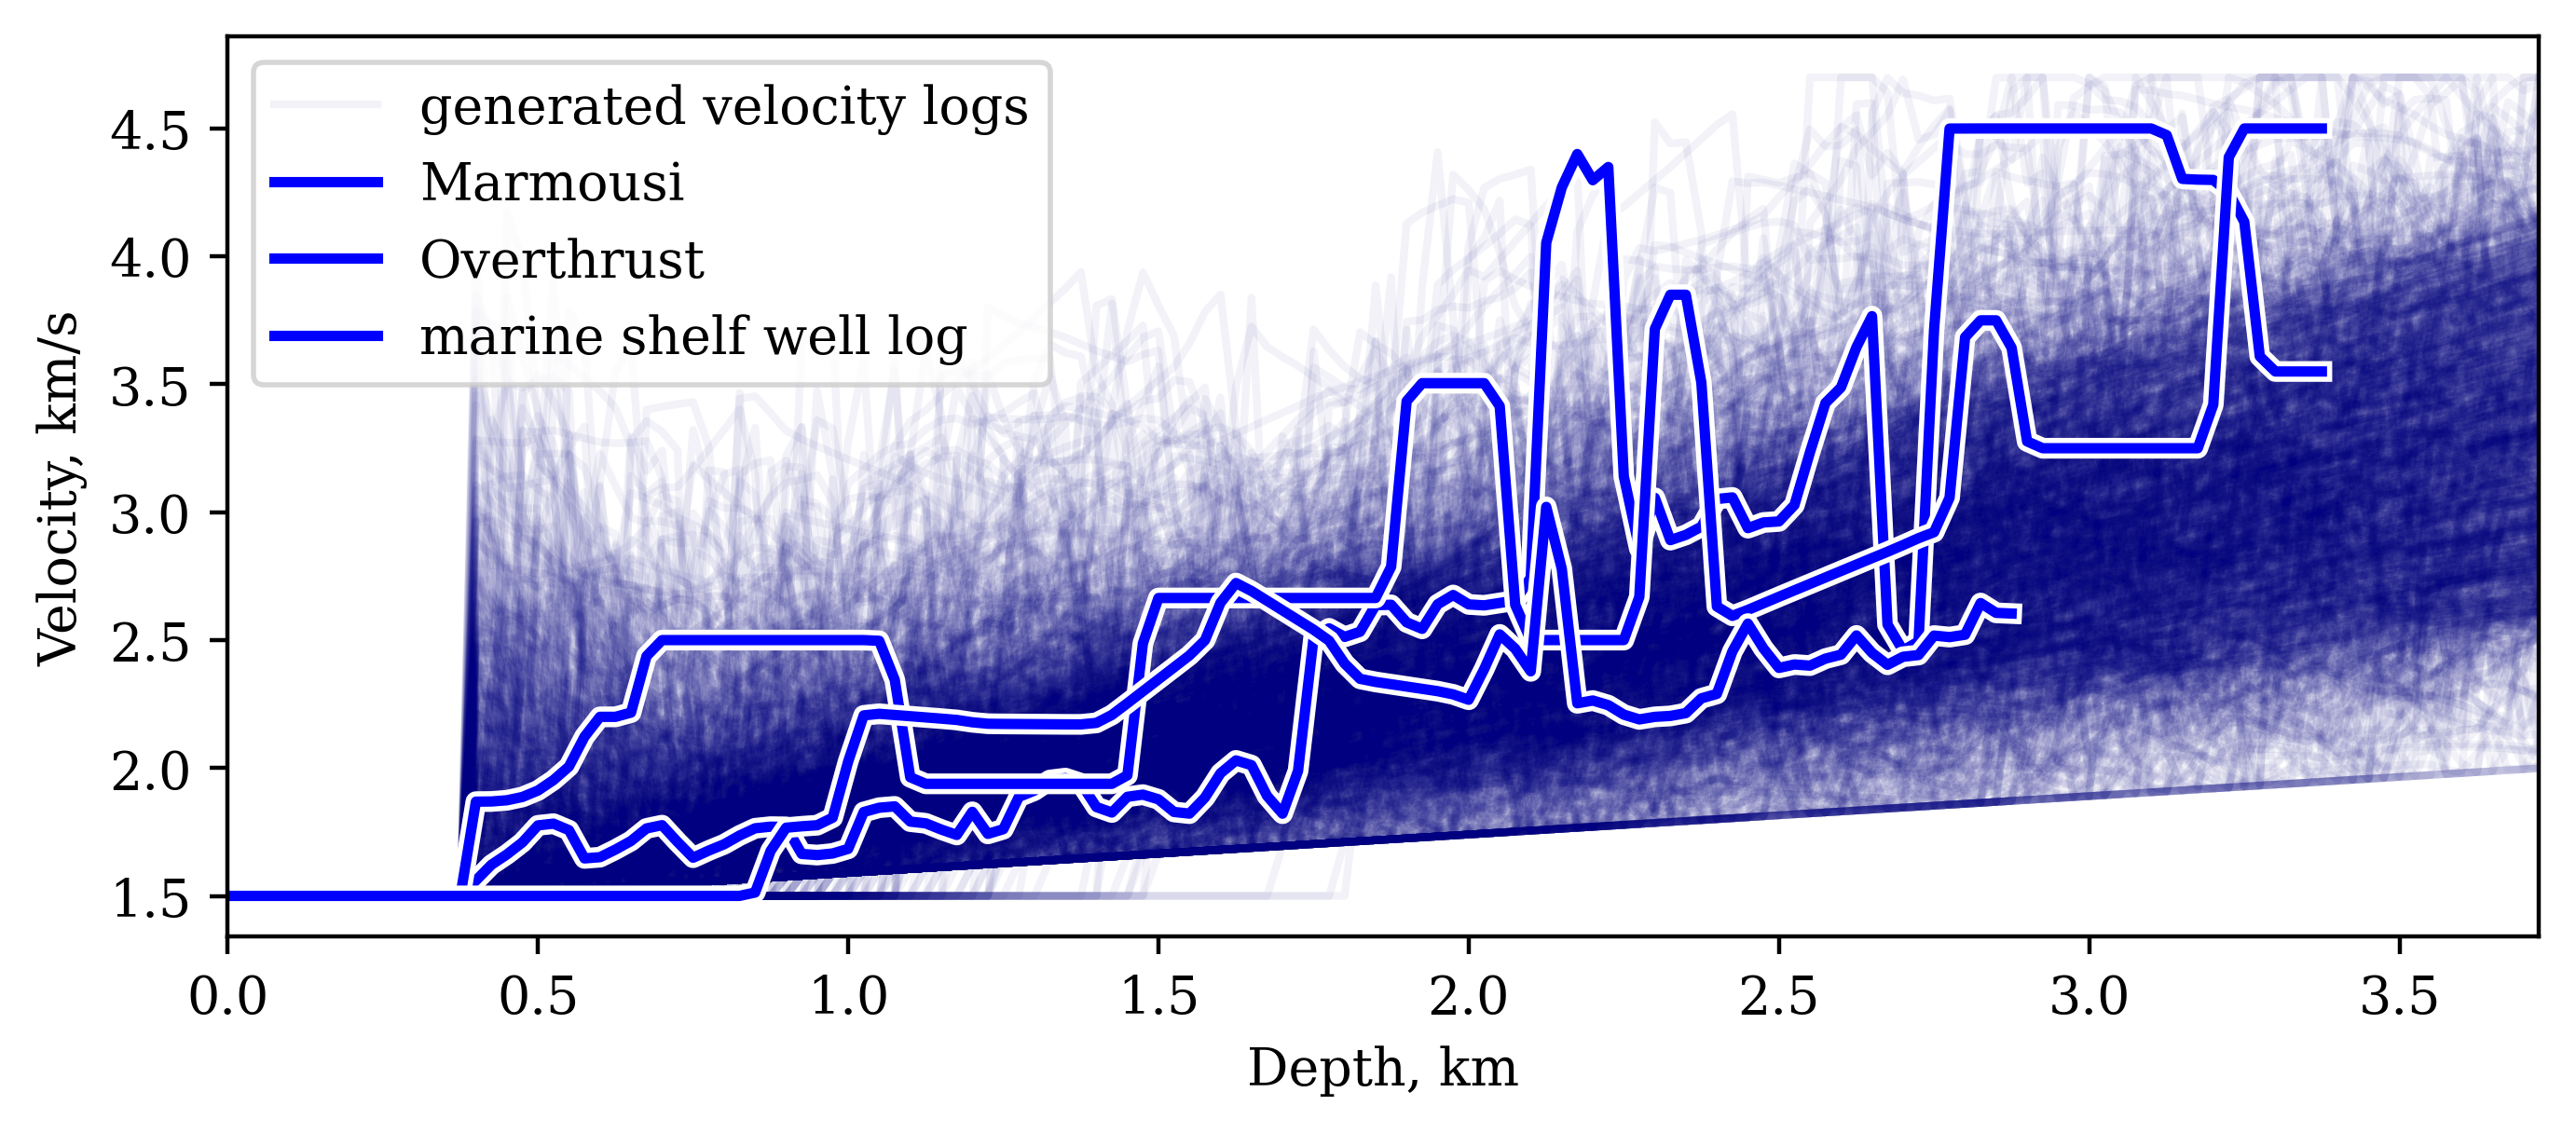

In [11]:
paper_pictures_root='/home/plotnips/Dropbox/Apps/Overleaf/draft_Geophysics_FWI_init_model_prediction/paper_geophysics/Fig'
log_idx = 100
############## Linear trends
water_sz=int(400/dz);print(dz)
zz = np.arange(136-water_sz)*dz
step=1500
water=np.ones((water_sz))*1500
zz_=dz*np.arange(len(np.concatenate([water,step + 0.2 * zz]))) / 1000
plt.figure(figsize=(8,3.2), dpi=400)
z_log=np.arange(model_log.vp.shape[0])*25/1000
well_log=np.flip(model_log.vp[:,0]/1000)

plt.xlabel('Depth, km'); plt.ylabel('Velocity, km/s')
plt.xlim([0,xax[-1]])
##############  Dataset models
nmodels=len(dataset_models_data)
print(nmodels)
for imodel in range(nmodels-1):
#     log = dataset_models_data[imodel]['initial_model'][:,log_idx] / 1000      # model
    log = dataset_models_data[imodel]['model'][:,log_idx] / 1000      # model
    xax = dx * np.arange(len(log)) / 1000
    if imodel==0:     plt.plot(xax, log, 'navy', alpha=0.05,label='generated velocity logs')
    else:       plt.plot(xax, log, 'navy', alpha=0.05)
############## Testing models
for i in range(len(test_models_data)):
    log = test_models_data[i]['model'][0:136,log_idx] / 1000
    if test_models_data[i]['name']=='model__cgg_lin_vp_long':   
        NAME='marine shelf well log'
    else:    
        NAME=test_models_data[i]['name'].split('model__')[1]
    if NAME=='Seam2':  NAME='SEAM'
    ###
    if NAME=='Marmousi':   color='g'
    if NAME=='Overthrust':   color='r'
    color='b'
    ###
    print(NAME)
    plt.plot(dx * np.arange(len(log)) / 1000, log, alpha=1.0,c='w',lw=4)
    plt.plot(dx * np.arange(len(log)) / 1000, log, alpha=1.0,label=NAME,lw=2,c=color)

plt.plot(z_log,well_log,c='w',lw=4)
plt.plot(z_log,well_log,label='marine shelf well log',lw=2,c='b')
plt.legend()
plt.savefig(os.path.join(paper_pictures_root,'vel_models.png'),dpi=400,bbox_inches='tight')

25
25
Marmousi
Overthrust


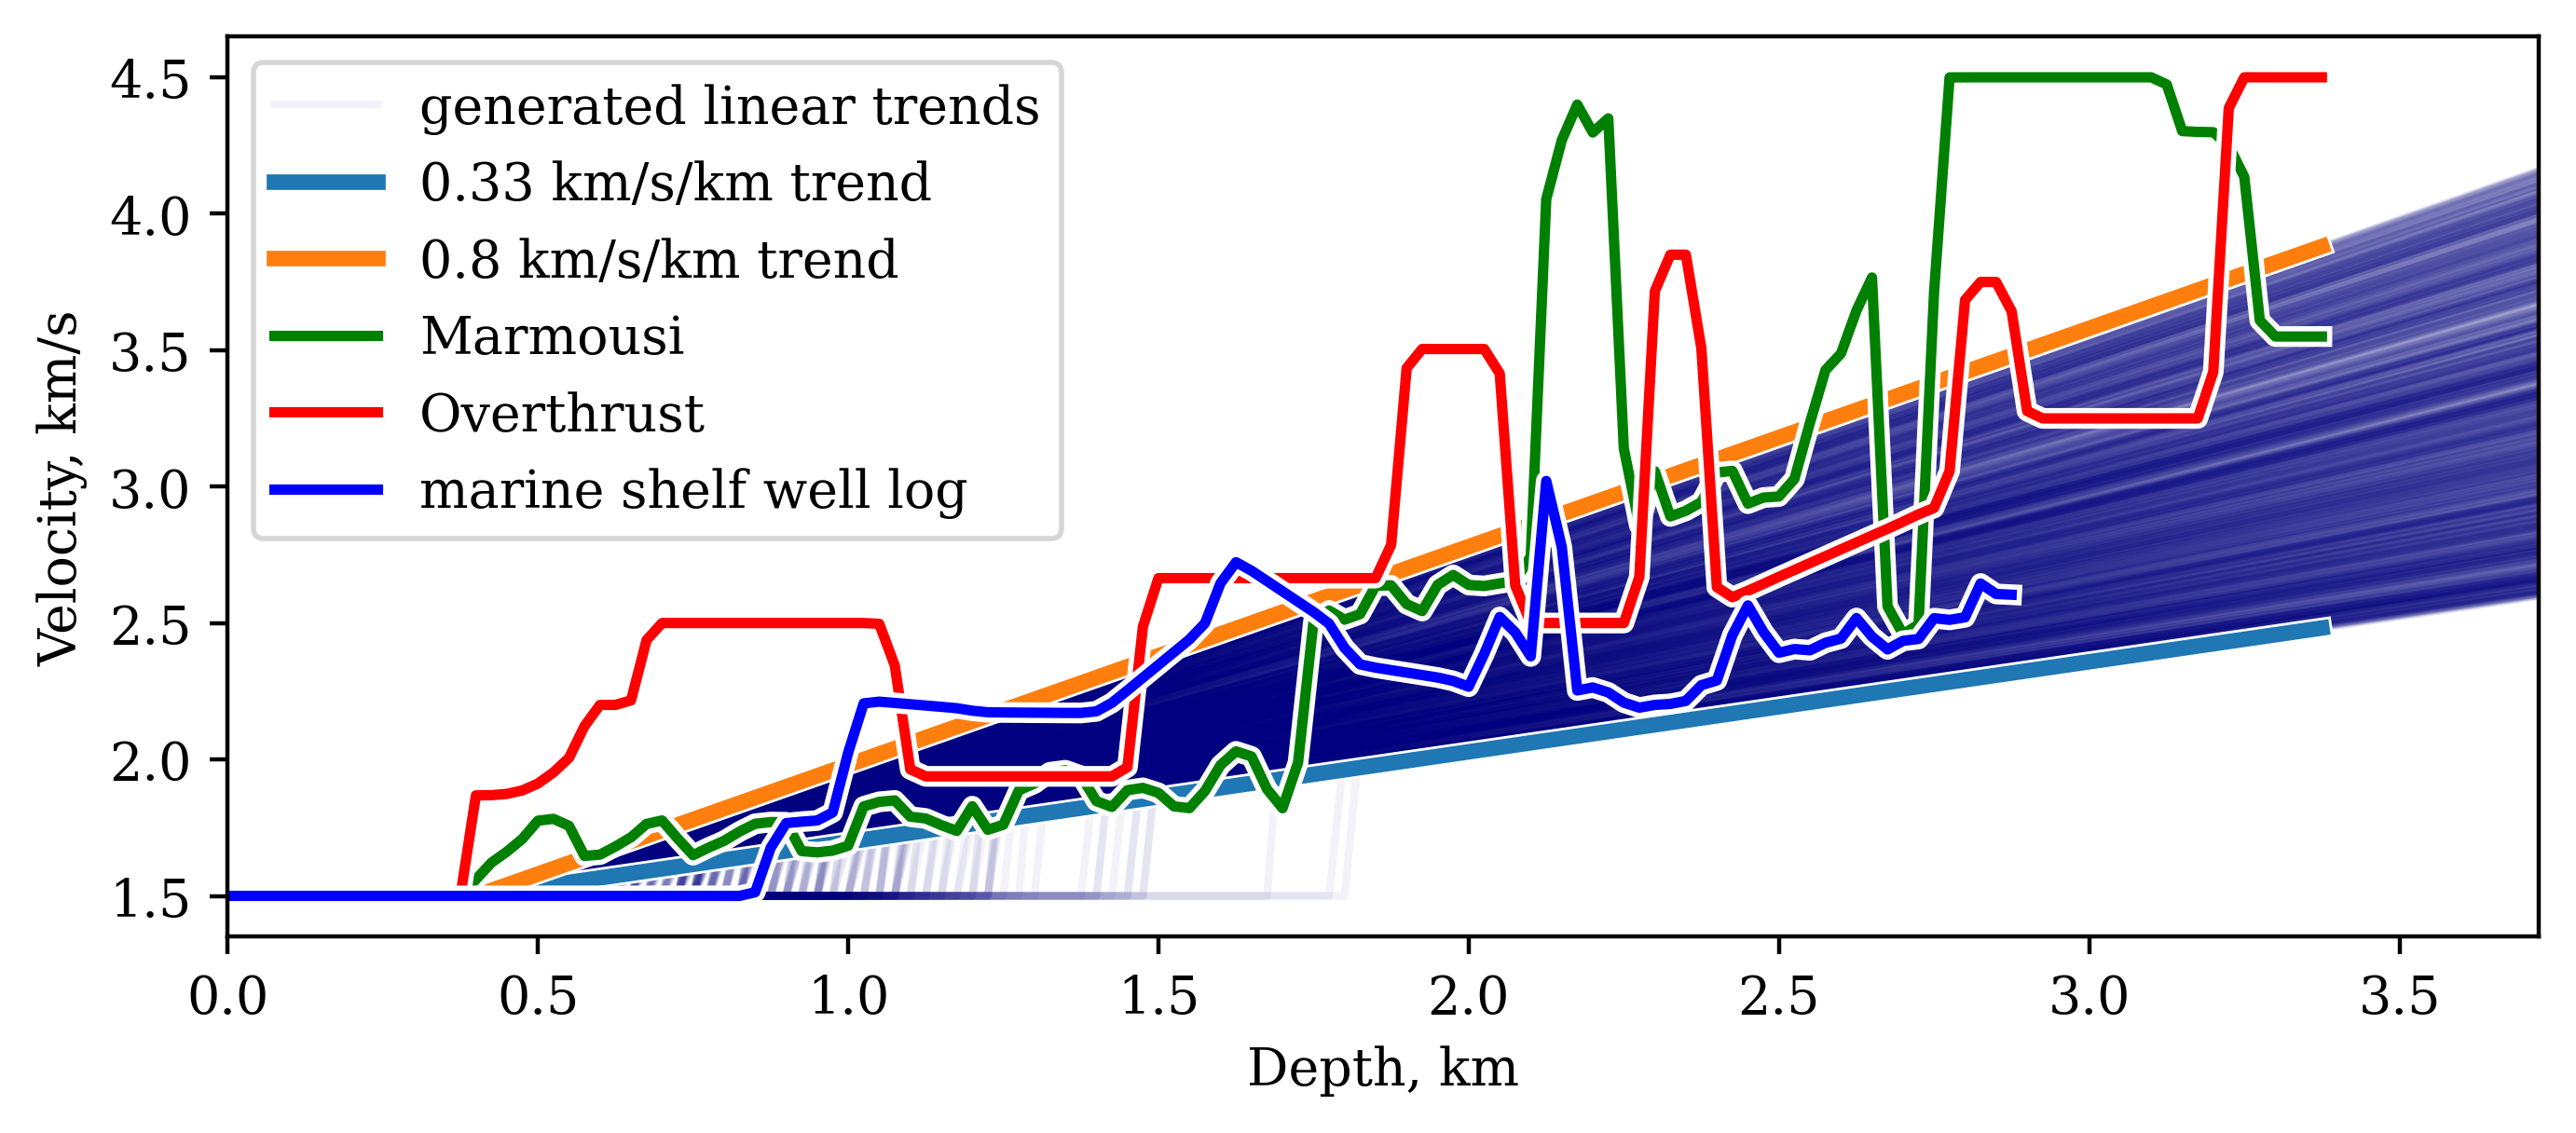

In [12]:
log_idx = 100
############## Linear trends
water_sz=int(400/dz);print(dz)
zz = np.arange(136-water_sz)*dz
step=1500
water=np.ones((water_sz))*1500
zz_=dz*np.arange(len(np.concatenate([water,step + 0.2 * zz]))) / 1000
z_log=np.arange(model_log.vp.shape[0])*25/1000
well_log=np.flip(model_log.vp[:,0]/1000)
############## Linear trends
water_sz=int(400/dz);print(dz)
zz = np.arange(136-water_sz)*dz
step=1500
water=np.ones((water_sz))*1500
zz_=dz*np.arange(len(np.concatenate([water,step + 0.2 * zz]))) / 1000


plt.figure(figsize=(8,3.2), dpi=400)
z_log=np.arange(model_log.vp.shape[0])*25/1000
well_log=np.flip(model_log.vp[:,0]/1000)
plt.xlabel('Depth, km'); plt.ylabel('Velocity, km/s')
plt.xlim([0,xax[-1]])
##############  Dataset models
nmodels=len(dataset_models_data)
for imodel in range(nmodels-1):
    log = dataset_models_data[imodel]['initial_model'][:,log_idx] / 1000      # model
    xax = dx * np.arange(len(log)) / 1000
    if imodel==0:     plt.plot(xax, log, 'navy', alpha=0.05,label='generated linear trends')
    else:       plt.plot(xax, log, 'navy', alpha=0.05)
############## Linear trends
plt.plot(zz_,np.concatenate([water,step + 0.33 * zz])/1000,c='w',lw=4.0)
plt.plot(zz_,np.concatenate([water,step + 0.33 * zz])/1000,label='0.33 km/s/km trend',lw=3.0)
plt.plot(zz_,np.concatenate([water,step + 0.8 * zz])/1000,c='w',lw=4.0)
plt.plot(zz_,np.concatenate([water,step + 0.8 * zz])/1000,label='0.8 km/s/km trend',lw=3.0)
############## Testing models
for i in range(len(test_models_data)):
    log = test_models_data[i]['model'][0:136,log_idx] / 1000
    if test_models_data[i]['name']=='model__cgg_lin_vp_long':   
        NAME='marine shelf well log'
    else:    
        NAME=test_models_data[i]['name'].split('model__')[1]
    if NAME=='Seam2':  NAME='SEAM'
    if NAME=='Marmousi':   color='g'
    if NAME=='Overthrust':   color='r'
    print(NAME)
    plt.plot(dx * np.arange(len(log)) / 1000, log, alpha=1.0,c='w',lw=4)
    plt.plot(dx * np.arange(len(log)) / 1000, log, alpha=1.0,label=NAME,lw=2,c=color)
plt.plot(z_log,well_log,c='w',lw=4)
plt.plot(z_log,well_log,label='marine shelf well log',lw=2,c='b')
plt.legend()
plt.savefig(os.path.join(paper_pictures_root,'initial_models.png'),dpi=400,bbox_inches='tight')

Marmousi
Overthrust


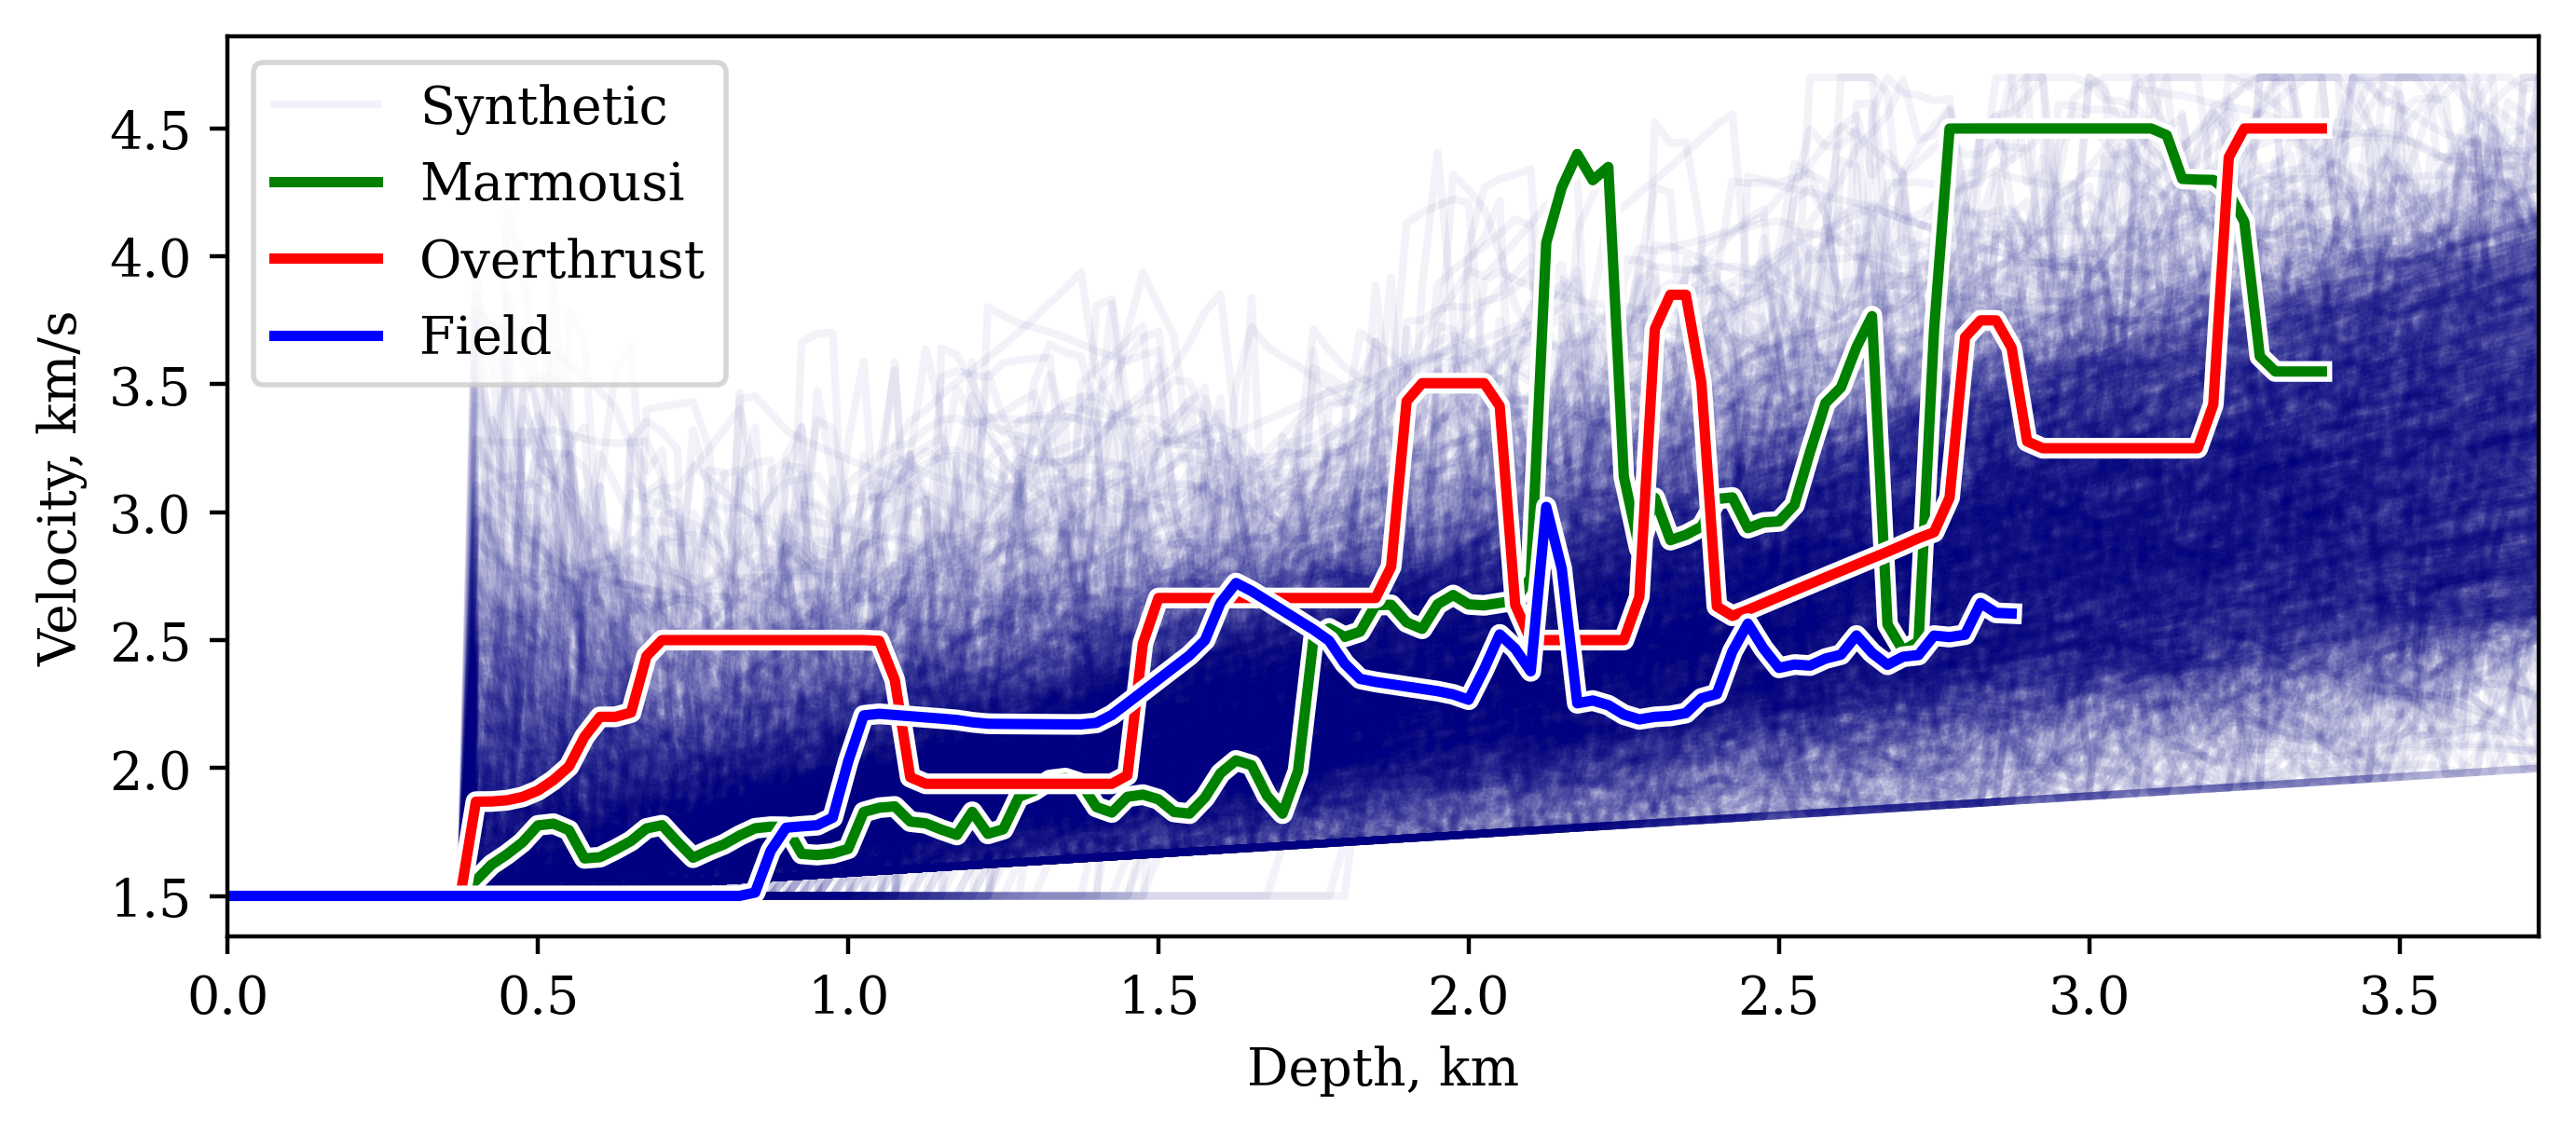

In [13]:
plotting_flag=0
if plotting_flag==1:
    plt.figure(figsize=(8,3.2),dpi=400)
    z_log=np.arange(model_log.vp.shape[0])*25/1000
    well_log=np.flip(model_log.vp[:,0]/1000)
    plt.xlabel('Depth, km'); plt.ylabel('Velocity, km/s')
    plt.xlim([0,xax[-1]])
    ##############  Dataset models
    nmodels=len(dataset_models_data)
    for imodel in range(nmodels-1):
        log = dataset_models_data[imodel]['model'][:,log_idx] / 1000      # model
        xax = dx * np.arange(len(log)) / 1000
        if imodel==0:     plt.plot(xax, log, 'navy', alpha=0.05,label='Synthetic')
        else:       plt.plot(xax, log, 'navy', alpha=0.05)
    ############## Testing models
    for i in range(len(test_models_data)):
        log = test_models_data[i]['model'][0:136,log_idx] / 1000
        if test_models_data[i]['name']=='model__cgg_lin_vp_long':   
            NAME='marine shelf well log'
        else:    
            NAME=test_models_data[i]['name'].split('model__')[1]
        if NAME=='Seam2':  NAME='SEAM'
        if NAME=='Marmousi':   color='g'
        if NAME=='Overthrust':   color='r'
        print(NAME)
        plt.plot(dx * np.arange(len(log)) / 1000, log, alpha=1.0,c='w',lw=4)
        plt.plot(dx * np.arange(len(log)) / 1000, log, alpha=1.0,label=NAME,lw=2,c=color)
    plt.plot(z_log,well_log,c='w',lw=4)
    plt.plot(z_log,well_log,label='Field',lw=2,c='b')
    plt.legend()
    plt.savefig(os.path.join(paper_pictures_root,'vel_models.png'),dpi=400,bbox_inches='tight')

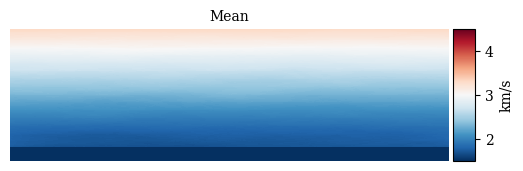

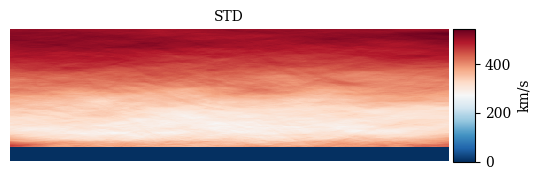

In [14]:
print
# Images
par_box = {'vmin': 1500, 'vmax': 4500}
par_box_km = {'vmin': 1.5, 'vmax': 4.5}
vis.plot_model(np.mean(other_models, 0) / 1000, title='Mean', axis='off', cax_label='km/s', 
#                colorbar=False,
               **par_box_km)
vis.plot_model(np.std(other_models, 0), title='STD', 
#                colorbar=False,
               axis='off')
# print(np.linspace(0, nmodels-1, 4))
# for i in [int(np.floor(x)) for x in np.linspace(0, nmodels-1, 4)]:
#     vis.plot_model(other_models[i], axis='off', colorbar=False, **par_box
# #                    title=f'Model {i+1} / {nmodels}'
#                   )

(1200, 150, 496)
Number of random model 450
AxesSubplot(0.125,0.536818;0.352273x0.343182)
AxesSubplot(0.547727,0.536818;0.352273x0.343182)
AxesSubplot(0.125,0.125;0.352273x0.343182)
AxesSubplot(0.547727,0.125;0.352273x0.343182)
Save /home/plotnips/Dropbox/Apps/Overleaf/draft_Geophysics_FWI_init_model_prediction/paper_geophysics/Fig/random_v.png


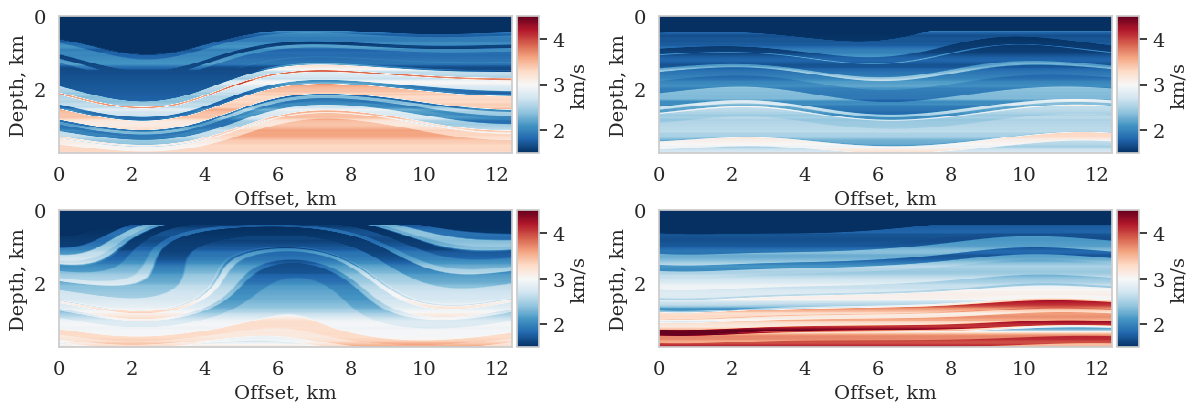

In [42]:
fontsize = 14
params = {
    'image.interpolation': 'nearest',
    'axes.grid': False,
    'font.family': 'serif',
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
}
plt.rcParams.update(params)
print(other_models.shape)
def plot_log_model(mm, dx, nx0=None, nz0=None, _src=None, title='', log=None, log_location=None, 
            ax=None,cmap='RdBu_r', axis=True,cax_label='km/s', **kwargs):
    v = mm.copy() / 1000
    print(ax)
    if ax is None:
        plt.figure(); 
        ax = plt.gca();
    nz, nx = mm.shape[-2:]
    im = ax.imshow(v[:,:nx0], cmap=cmap, extent=[0, 
                                                 nx0 * dx / 1000 if nx0 else nx * dx / 1000, 
                                                 0, 
                                                 nz0 * dx/  1000 if nz0 else nz * dx / 1000],
                   origin='upper', **kwargs); 
    divider = make_axes_locatable(ax); 
    cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax); cbar.set_label(cax_label);
    if axis:
        ax.set_xlabel('Offset, km'); ax.set_ylabel('Depth, km'); ax.set_title(title); 
    else:
        ax.axis('off')
    ax.invert_yaxis();
        
# for i in range(30):
#     vis.plot_log_model(np.flipud(other_models[i,::]),25,title=str(i),vmin=1.500,vmax=4.500)

ii=2
ii=450
# ii=random.randint(0,len(other_models))
print('Number of random model',ii)
fig, axx = plt.subplots(2, 2, figsize=(12,4.5))
plot_log_model(np.flipud(other_models[ii,::]),25,vmin=1.500,vmax=4.500  ,ax=axx[0,0])
plot_log_model(np.flipud(other_models[ii+2,::]),25,vmin=1.500,vmax=4.500,ax=axx[0,1])
plot_log_model(np.flipud(other_models[ii+3,::]),25,vmin=1.500,vmax=4.500,ax=axx[1,0])
plot_log_model(np.flipud(other_models[ii+4,::]),25,vmin=1.500,vmax=4.500,ax=axx[1,1])
plt.subplots_adjust(left=0.05,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.17
                   )
vis.savefig('random_v.png')

In [16]:
print(nmodels)
vol = np.concatenate([np.expand_dims(m, 0) for m in other_models], 0)
print(vol.shape)

1200
(1200, 150, 496)


(1200, 150, 496)
(1200, 150, 496)
(1200, 150)
150
(1200,)


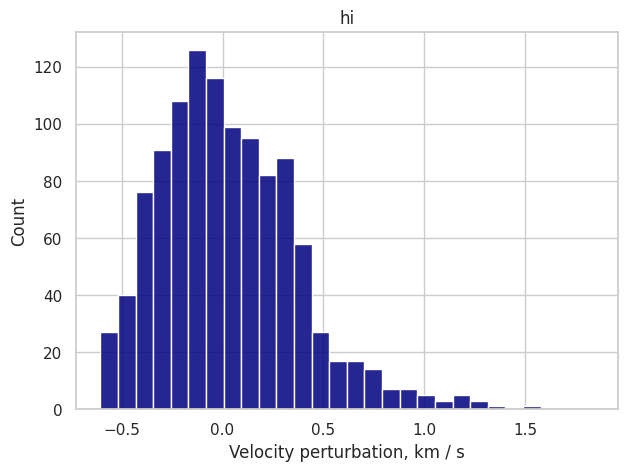

In [17]:
# dist = np.mean((vol - np.mean(vol, keepdims=True))[:, :, log_idx], 1)
the_log = (vol - np.mean(vol, keepdims=True))[:, :, idx_dist] / 1000
dist = the_log[:, the_log.shape[-1] // 2]
print((vol - np.mean(vol, keepdims=True)).shape)
print(vol.shape)
print(the_log.shape)
print(the_log.shape[-1])
print(dist.shape)

sns.set(style='whitegrid', 
#         palette="deep", 
        palette="Blues_r", 
        rc={"figure.figsize": [7, 5]})


sns.histplot(dist, kde=False, stat='count', 
            color = 'navy',
            alpha = 0.85,
             line_kws={ 'color': 'k', 'linestyle': 'dashed', 'linewidth': 2},
             binrange=(0.99 * np.min(dist), 0.9 * np.max(dist)),
            ).set(xlabel='Velocity perturbation, km / s', ylabel='Count',title='hi');